## Tutorial

This tutorial is for offering a guidance to use the package with a one simple callable function.<br>
You only need to prepare a root path for task-based fMRI data. 


In [1]:
from pathlib import Path
import pandas as pd

#### Example data

The example data is a mini-size version of the dataset issued by Bornstein et al., 2017 ([paper](https://www.nature.com/articles/nn.4573#abstracthttps://www.nature.com/articles/nn.4573#abstract),[openneuro](https://openneuro.org/datasets/ds001607/versions/1.0.1)).<br>
And the data includes 8 subjects and each of them has one run for Reinforcement Learning task with 180 trials. <br>
You can download the zip file from the [link]().

In [2]:
bids_layout = "mini_bornstein2017"
report_path = "results"
Path(report_path).mkdir(exist_ok=True)

### Input data format

#### BIDS layout with original data

The original task-based fMRI data should be in **bids_layout**.<br> 
Also, you need to place preprocessed fMRI images under the *derivatives* folder, nameed as **fmriprep**.<br>
In the original layoout of sample data, there are only events files as the preprocessed images will be used.<br>

In [3]:
!ls mini_bornstein2017

dataset_description.json  masks   sub-02  sub-04  sub-06  sub-08
derivatives		  sub-01  sub-03  sub-05  sub-07


The original BIDS layout is used for locating behavioral data ("events.tsv")

In [4]:
pd.read_table('mini_bornstein2017/sub-01/func/sub-01_task-multiarmedbandit_events.tsv').head()

,Unnamed: 0,onset,duration,type,choice,rwdval,RT,time_feedback,gain,loss,PrecalculatedQchosen,PrecalculatedPEchosen
0,0,8.320,3,bandit,1,0,1.2439,11.5639,0,0,0.000000,0.000000
1,1,15.303,3,bandit,2,10,0.7019,18.0049,10,0,0.000000,4.897044
2,2,22.286,3,bandit,3,0,0.9651,25.2511,0,0,0.000000,0.000000
3,3,29.269,3,bandit,3,10,1.0103,32.2793,10,0,0.000000,4.897044
4,4,36.253,3,bandit,2,0,0.4705,38.7235,0,0,0.733677,-0.733677


#### Derivative layout from *fMRIPrep*

The package assumes that preprocessing images is done by [fMRIPrep](https://fmriprep.org/en/stable/).<br>
Please refer to "mbfmri/utils/config.py" for configuration of it.<br> You might change configuration here to apply this package to data preprocessed by other tool than fMRIPrep.

In [5]:
!ls mini_bornstein2017/derivatives/fmriprep

dataset_description.json  sub-02  sub-04  sub-06  sub-08
sub-01			  sub-03  sub-05  sub-07


In [6]:
!ls mini_bornstein2017/derivatives/fmriprep/sub-01/func/

sub-01_task-multiarmedbandit_desc-confounds_regressors.tsv
sub-01_task-multiarmedbandit_space-MNI152NLin2009cAsym_desc-preproc_bold.json
sub-01_task-multiarmedbandit_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


#### Mask images

The mask images would be located under the below folder as default.<br>
The images here are integrated into one binary image.

In [7]:
!ls mini_bornstein2017/masks/include

 gain_uniformity-test_z_FDR_0.01.nii.gz
 loss_association-test_z_FDR_0.01.nii.gz
 loss_uniformity-test_z_FDR_0.01.nii.gz
'prediction error_association-test_z_FDR_0.01.nii.gz'
'prediction error_uniformity-test_z_FDR_0.01.nii.gz'
 reward_association-test_z_FDR_0.01.nii.gz
 reward_uniformity-test_z_FDR_0.01.nii.gz


### Run MB-MVPA

The next part is finally about running the MB-MVPA package.<br>
Before proceeding, you need to choose which computational model to use.<br>
Please refer to [hBayesDM](https://hbayesdm.readthedocs.io/en/v1.0.1/models.html) and check available models.<br>
Also, the data in "events.tsv" should match with input format of the corresponding model.<br>
If not and you don't want to change your original data, you can use user-defined functions to remap the data while preprocessing.<br>
Please refer to "mbfmri.preprocessing.events.py."
Generated voxel feature data and latent process signals will be saved in new derivative layout called "MB-MVPA."
As default, the MB-MVPA derivative will be under the same derivative folder as the fMRIPrep.

#### hBayesDM model

The task of the example data can be categorizeed as multi-armed bandit task, learing the probability of three cards (or bandits) by rewards or none.
The chosen computational model in the below example is a Hierarchical Bayesian Modeling of the Multi-Armed Bandit Task using 5 Parameter Model, without C (choice perseveration) but with xi (noise) and decay rate [Niv et al., 2015](https://www.jneurosci.org/content/35/21/8145).


#### Target latent process

The target latent process is the *prediction error* of chosen options, *PEchosen*, in this example. Please refer to the [available latent process list]() for other possible processes and their explanations.

#### MVPA model

For the Multi-voxel Pattern Analysis (MVPA), **ElasticNet** is used as default.<br>
The package depends on [glmnet Python package](https://github.com/civisanalytics/python-glmnet) for fitting ElasticNet.
You will get plots for lambda searching and coefficients values as the convention of employing ElasticNet.

#### Cross-validation

The *run_mbfmri* employs a cross-validation framework to secure validity.<br>
Currently, two options are available, "N-fold" for N-fold cross-valiidationa and "N-lnso" for leave-n-subjects-out.<br>
You can enter the method through *method* argument.<br>
The pearsonr correlation plot will be generated using the results from cross-validation.<br>
All the visible reports and results are integrated from the results of each fold.<br>
(You can also locate raw result of each fold in the report folder.)

#### Brain activation map

The final output and the purpose of the MB-MVPA is a brain activation pattern map attributed to the target latent process.<br>
This will be obtained by interpreting the MVPA model. For ElasticNet, it means reading coefficients of the linear layer.<br>
You can find the nii image under the "brain_map" folder in the reports.

In [10]:
#import hbayesdm
#from hbayesdm.models import banditNarm_lapse_decay


/home/heesun/.cache/pypoetry/virtualenvs/model-based-fmri-AnCbJ7Cu-py3.7/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)
/home/heesun/.cache/pypoetry/virtualenvs/model-based-fmri-AnCbJ7Cu-py3.7/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
Instructions for updating:
non-resource variables are not supported in the long term


INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: setting functions
INFO: start loading & intergrating masks to include
      gain_uniformity-test_z_FDR_0.01.nii: 7052/902629
      reward_association-test_z_FDR_0.01.nii: 13067/902629
      loss_association-test_z_FDR_0.01.nii: 625/902629
      loss_uniformity-test_z_FDR_0.01.nii: 9196/902629
      reward_uniformity-test_z

[2/2]: 100%|██████████| 2/2 [01:55<00:00, 57.70s/it]


INFO: fMRI processing is done.
INFO: start model comparison-['banditNarm_lapse_decay']
INFO: running computational model [hBayesDM-banditNarm_lapse_decay]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL banditNarm_lapse_decay_d74b99f100f141b2c5b4e32f85280f4d NOW.



Model  = banditNarm_lapse_decay
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 8
 # of (max) trials per subject  = 180
 `Narm` is set to               = None

Using cached StanModel: /tmp/cached-hBayesDM_model-banditNarm_lapse_decay-pystan_2.19.1.1_user-1012.pkl
Index(['unnamed: 0', 'onset', 'duration', 'type', 'choice', 'rwdval', 'rt',
       'timefeedback', 'gain', 'loss', 'precalculatedqchosen',
       'precalculatedpechosen', 'trial', 'subjid', 'run', 'session'],
      dtype='object')
['Unnamed: 0', 'onset', 'duration', 'type', 'choice', 'rwdval', 'RT', 'time_feedback', 'gain', 'loss', 'PrecalculatedQchosen', 'PrecalculatedPEchosen', 'trial', 'subjID', 'run', 'session']
************************************
**** Model fitting is complete! ****
************************************


Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


INFO: model comparison done
                    model        value criterion
0  banditNarm_lapse_decay  2120.746911     looic
INFO: the best model is banditNarm_lapse_decay
INFO: indivudal parameters table
  subjID      Arew      Apun         R          P        xi         d
0     01  0.439838  0.502000  0.490360  14.958661  0.026151  0.416641
1     02  0.635754  0.502576  0.098867  14.968765  0.029592  0.341070
2     03  0.658329  0.502562  0.751799  14.984605  0.029453  0.440954
3     04  0.897282  0.503521  0.527837  14.979193  0.026998  0.376644
4     05  0.851341  0.503118  0.352062  14.983867  0.027800  0.390917
5     06  0.642172  0.503039  0.954614  14.955344  0.025099  0.406447
6     07  0.848062  0.502244  0.386015  14.974610  0.028043  0.382110
7     08  0.532705  0.503317  0.412858  14.953403  0.029738  0.442654
INFO: start processing 8 events.[task-multiarmedbandit, process-PEchosen]


8it [00:00, 16.61it/s]


INFO: events processing is done.
INFO: processed data [8/8] are plotted for quality check.
INFO: retrieving from BIDS Layout: ...rnstein2017/derivatives/mbmvpa | Subjects: 8 | Sessions: 0 | Runs: 0
      task-multiarmedbandit, process-PEchosen, feature-zoom2rgrout
INFO: start loading data


INFO: loaded data info. total-16
         subject_01: X(682, 3762), y(682, 1)
         subject_02: X(704, 3762), y(704, 1)
         subject_03: X(689, 3762), y(689, 1)
         subject_04: X(685, 3762), y(685, 1)
         subject_05: X(685, 3762), y(685, 1)
         subject_06: X(675, 3762), y(675, 1)
         subject_07: X(674, 3762), y(674, 1)
         subject_08: X(720, 3762), y(720, 1)
INFO: loaded voxel mask(46, 55, 46)
INFO: loading data done
INFO: start running the experiment. ElasticNet_alpha-0.001
INFO: fitting result[repeat-1/1,fold-1/5]:
         r_train                       0.26912
         r_pvalue_train                0.00000
         r_test                        0.09213
         r_pvalue_test                 0.00220
         mse_train                     0.34809
         mse_test                      0.12798
INFO: fitting result[repeat-1/1,fold-2/5]:
         r_train                       0.27645
         r_pvalue_train                0.00000
         r_test           

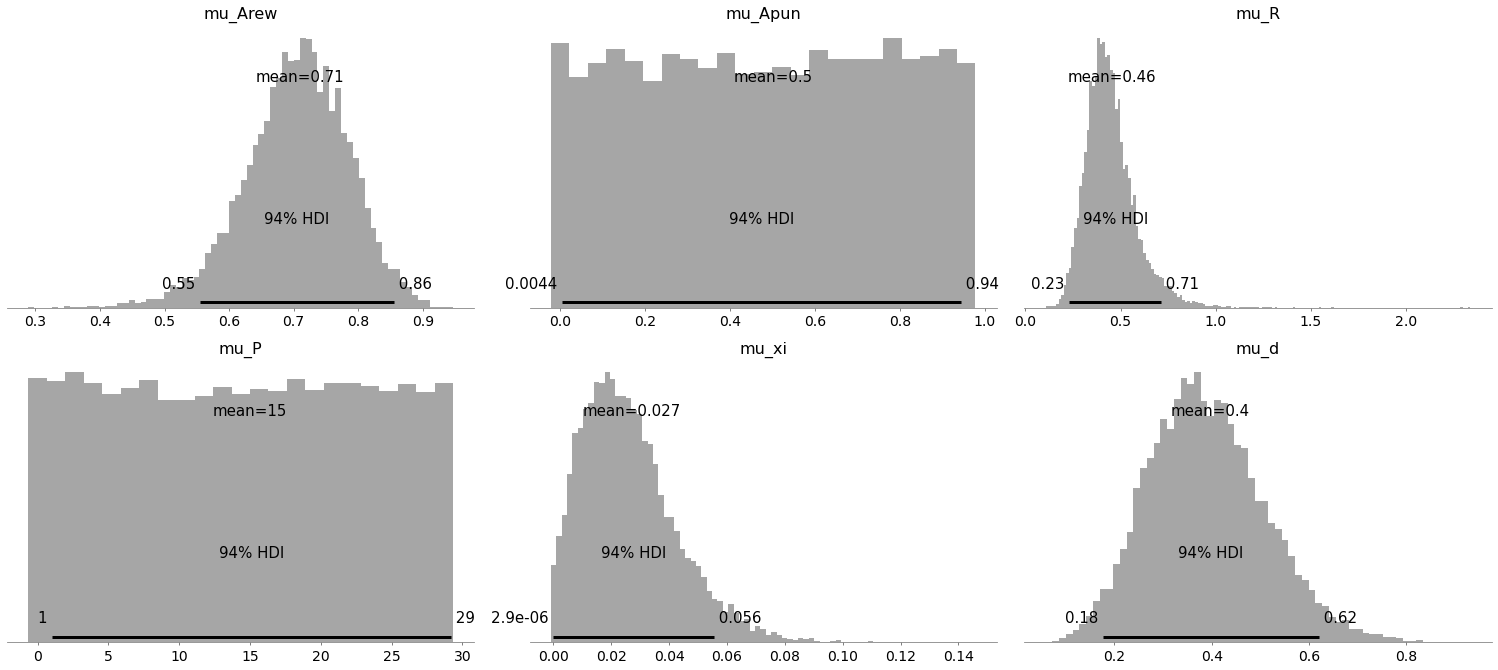

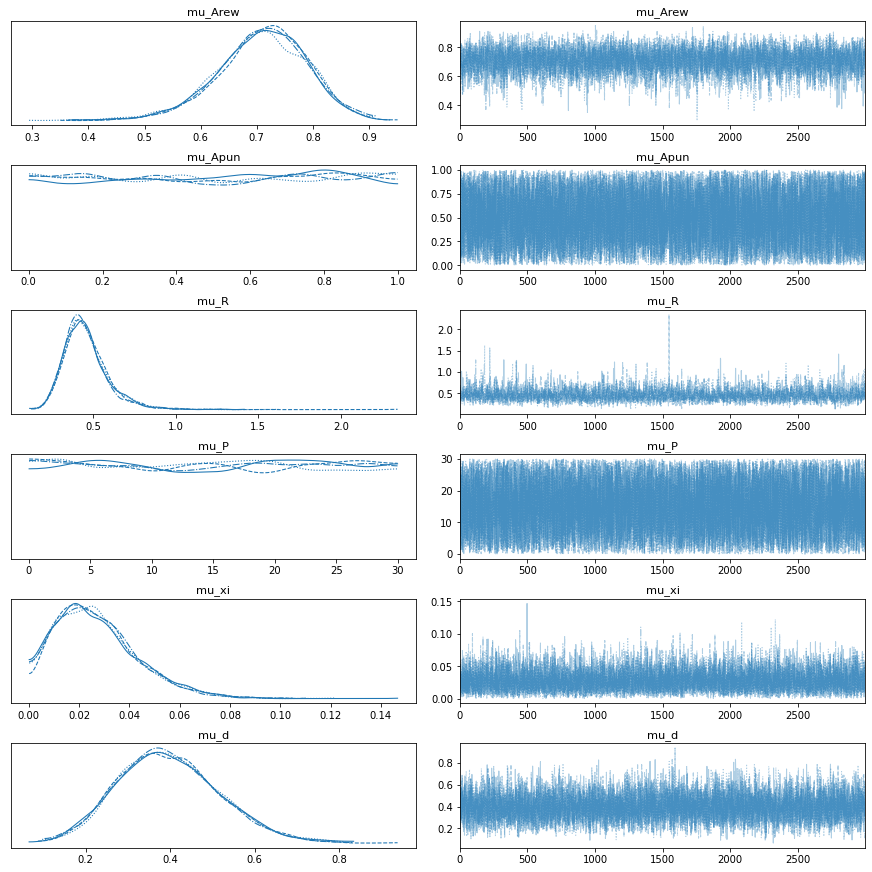

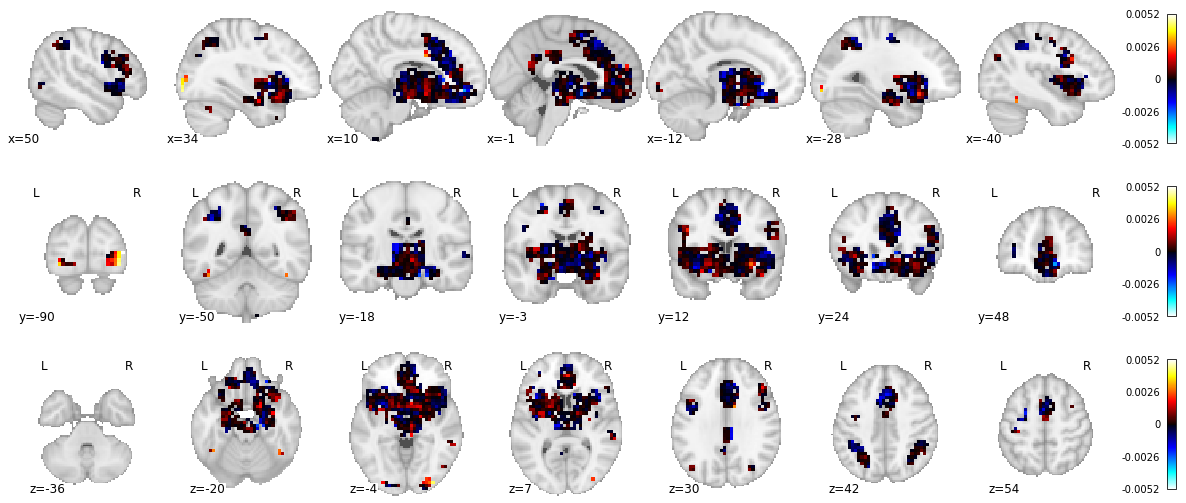

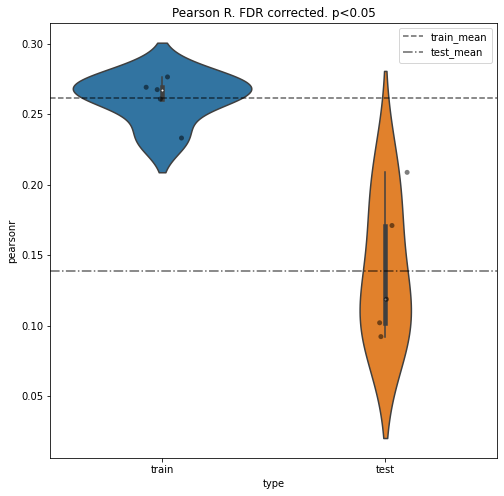

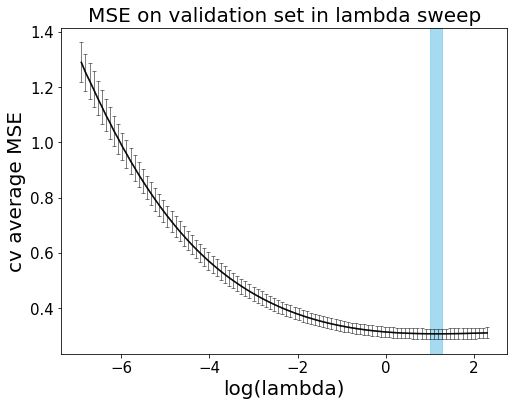

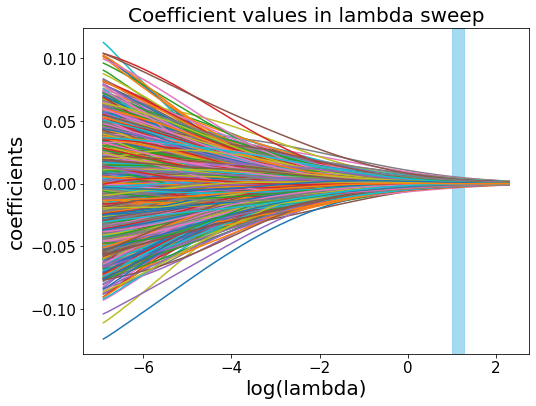

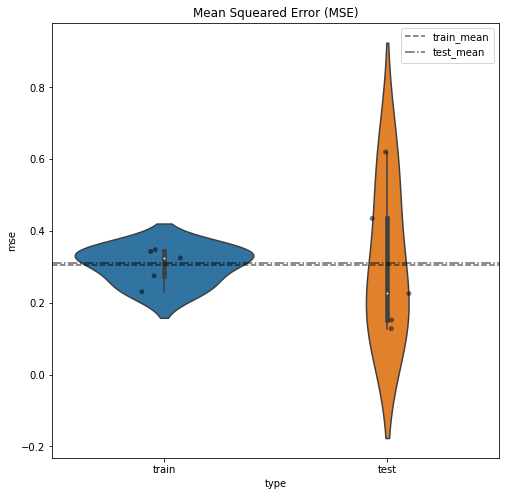

INFO: report(s)-['brainmap', 'pearsonr', 'elasticnet', 'mse'] is(are) done.
INFO: running done.


In [11]:
from mbfmri.core.engine import run_mbfmri
import hbayesdm

_ = run_mbfmri(analysis='mvpa',                     # name of analysis
               bids_layout='mini_bornstein2017',    # data
               mvpa_model='elasticnet',             # MVPA model
               dm_model= 'banditNarm_lapse_decay',  # computational model
               feature_name='zoom2rgrout',          # indentifier for processed fMRI data
               task_name='multiarmedbandit',       # identifier for task
               process_name='PEchosen',             # identifier for target latent process
               subjects='all',                      # list of subjects to include
               method='5-fold',                     # type of cross-validation
               report_path=report_path,             # save path for reporting results
               confounds=["trans_x", "trans_y",     # list of confounds to regress out
                          "trans_z", "rot_x",
                          "rot_y", "rot_z"],
               n_core=4,                            # number of core for multi-processing in hBayesDM
               n_thread=4,                          # number of thread for multi-threading in generating voxel features
               overwrite=True,                      # indicate if re-run and overwriting are required
               refit_compmodel=True,                # indicate if refitting comp. model is required
              )

#### Q value as target latent process

INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: setting functions
INFO: existing voxel mask is loaded.: 3762/116380
INFO: start processing 0 fMRI. (nii_img/thread)*(n_thread)=0*4. 8 image(s) is(are) skipped.


0it [00:00, ?it/s]

INFO: fMRI processing is done.


INFO: start model comparison-['banditNarm_lapse_decay']
INFO: individual parameters are loaded
INFO: model comparison done
                    model        value criterion
0  banditNarm_lapse_decay  2120.746911     looic
INFO: the best model is banditNarm_lapse_decay
INFO: indivudal parameters table
  subjID      Arew      Apun         R          P        xi         d
0     01  0.439838  0.502000  0.490360  14.958661  0.026151  0.416641
1     02  0.635754  0.502576  0.098867  14.968765  0.029592  0.341070
2     03  0.658329  0.502562  0.751799  14.984605  0.029453  0.440954
3     04  0.897282  0.503521  0.527837  14.979193  0.026998  0.376644
4     05  0.851341  0.503118  0.352062  14.983867  0.027800  0.390917
5     06  0.642172  0.503039  0.954614  14.955344  0.025099  0.406447
6     07  0.848062  0.502244  0.386015  14.974610  0.028043  0.382110
7     08  0.532705  0.503317  0.412858  14.953403  0.029738  0.442654
INFO: start processing 8 events.[task-multiarmedbandit, process-Qchos

8it [00:00, 17.30it/s]


INFO: events processing is done.
INFO: processed data [8/8] are plotted for quality check.
INFO: retrieving from BIDS Layout: ...rnstein2017/derivatives/mbmvpa | Subjects: 8 | Sessions: 0 | Runs: 0
      task-multiarmedbandit, process-Qchosen, feature-zoom2rgrout
INFO: start loading data


INFO: loaded data info. total-16
         subject_01: X(683, 3762), y(683, 1)
         subject_02: X(705, 3762), y(705, 1)
         subject_03: X(690, 3762), y(690, 1)
         subject_04: X(686, 3762), y(686, 1)
         subject_05: X(686, 3762), y(686, 1)
         subject_06: X(676, 3762), y(676, 1)
         subject_07: X(675, 3762), y(675, 1)
         subject_08: X(721, 3762), y(721, 1)
INFO: loaded voxel mask(46, 55, 46)
INFO: loading data done
INFO: start running the experiment. ElasticNet_alpha-0.001
INFO: fitting result[repeat-1/1,fold-1/5]:
         r_train                       0.23523
         r_pvalue_train                0.00000
         r_test                        0.23294
         r_pvalue_test                 0.00000
         mse_train                     0.19278
         mse_test                      0.07377
INFO: fitting result[repeat-1/1,fold-2/5]:
         r_train                       0.22226
         r_pvalue_train                0.00000
         r_test           

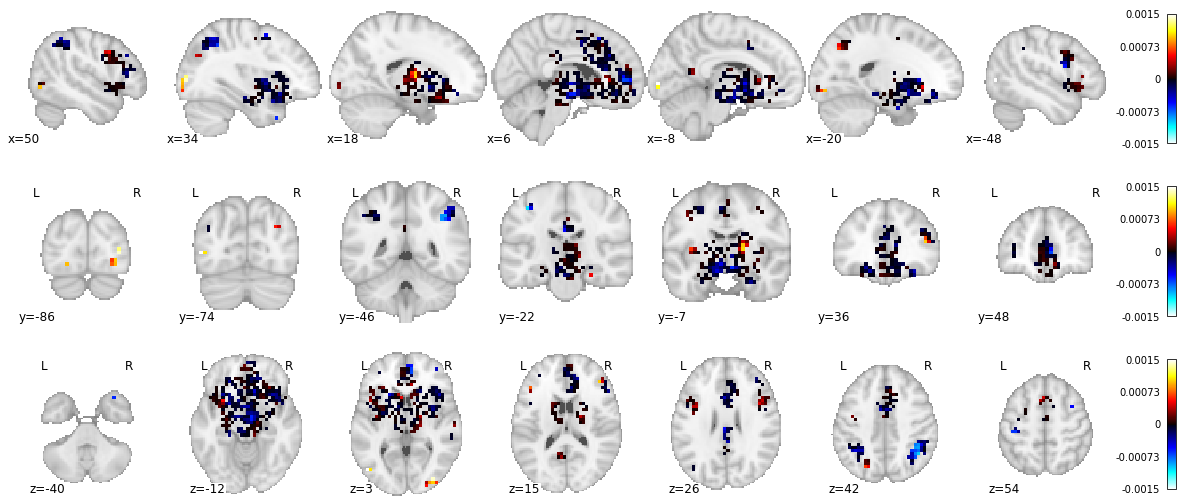

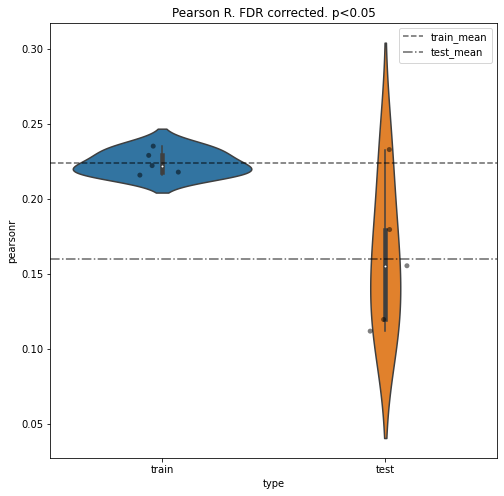

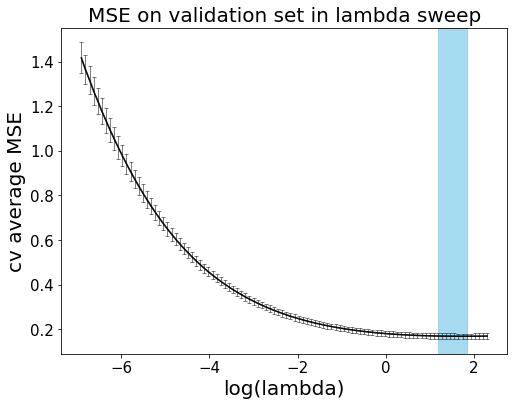

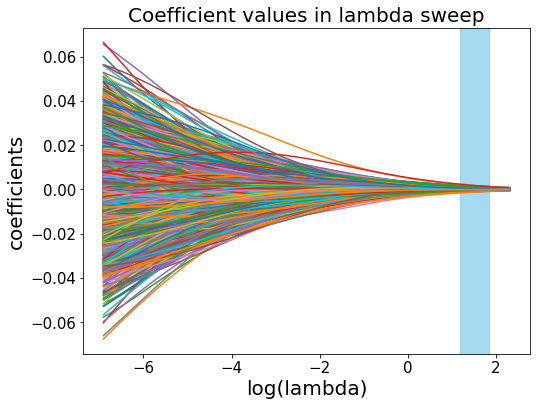

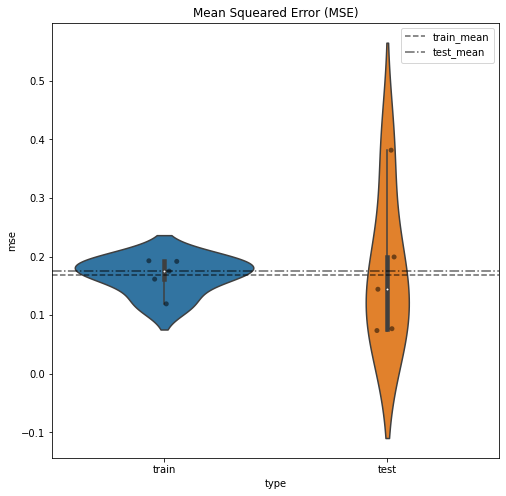

INFO: report(s)-['brainmap', 'pearsonr', 'elasticnet', 'mse'] is(are) done.
INFO: running done.


In [12]:
_ = run_mbfmri(analysis='mvpa',                     # name of analysis
               bids_layout='mini_bornstein2017',    # data
               mvpa_model='elasticnet',             # MVPA model
               dm_model= 'banditNarm_lapse_decay',  # computational model
               feature_name='zoom2rgrout',          # indentifier for processed fMRI data
               task_name='multiarmedbandit',        # identifier for task
               process_name='Qchosen',              # identifier for target latent process
               subjects='all',                      # list of subjects to include
               method='5-fold',                     # type of cross-validation
               report_path=report_path,             # save path for reporting results
               confounds=["trans_x", "trans_y",     # list of confounds to regress out
                          "trans_z", "rot_x",
                          "rot_y", "rot_z"],
               n_core=4,                            # number of core for multi-processing in hBayesDM
               n_thread=4,                          # number of thread for multi-threading in generating voxel features
              )

### Use precalculated latent process

INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: setting functions
INFO: existing voxel mask is loaded.: 3762/116380
INFO: start processing 0 fMRI. (nii_img/thread)*(n_thread)=0*4. 8 image(s) is(are) skipped.


0it [00:00, ?it/s]

INFO: fMRI processing is done.


INFO: indivudal parameters table
ignored
INFO: start processing 8 events.[task-multiarmedbandit, process-PrecalculatedPEchosen]


8it [00:00, 16.34it/s]


INFO: events processing is done.
INFO: processed data [8/8] are plotted for quality check.
INFO: retrieving from BIDS Layout: ...rnstein2017/derivatives/mbmvpa | Subjects: 8 | Sessions: 0 | Runs: 0
      task-multiarmedbandit, process-PrecalculatedPEchosen, feature-zoom2rgrout
INFO: start loading data


INFO: loaded data info. total-16
         subject_01: X(683, 3762), y(683, 1)
         subject_02: X(705, 3762), y(705, 1)
         subject_03: X(690, 3762), y(690, 1)
         subject_04: X(686, 3762), y(686, 1)
         subject_05: X(686, 3762), y(686, 1)
         subject_06: X(676, 3762), y(676, 1)
         subject_07: X(675, 3762), y(675, 1)
         subject_08: X(721, 3762), y(721, 1)
INFO: loaded voxel mask(46, 55, 46)
INFO: loading data done
INFO: start running the experiment. ElasticNet_alpha-0.001
INFO: fitting result[repeat-1/1,fold-1/5]:
         r_train                       0.24341
         r_pvalue_train                0.00000
         r_test                        0.04775
         r_pvalue_test                 0.11282
         mse_train                     0.35457
         mse_test                      0.12868
INFO: fitting result[repeat-1/1,fold-2/5]:
         r_train                       0.28524
         r_pvalue_train                0.00000
         r_test           

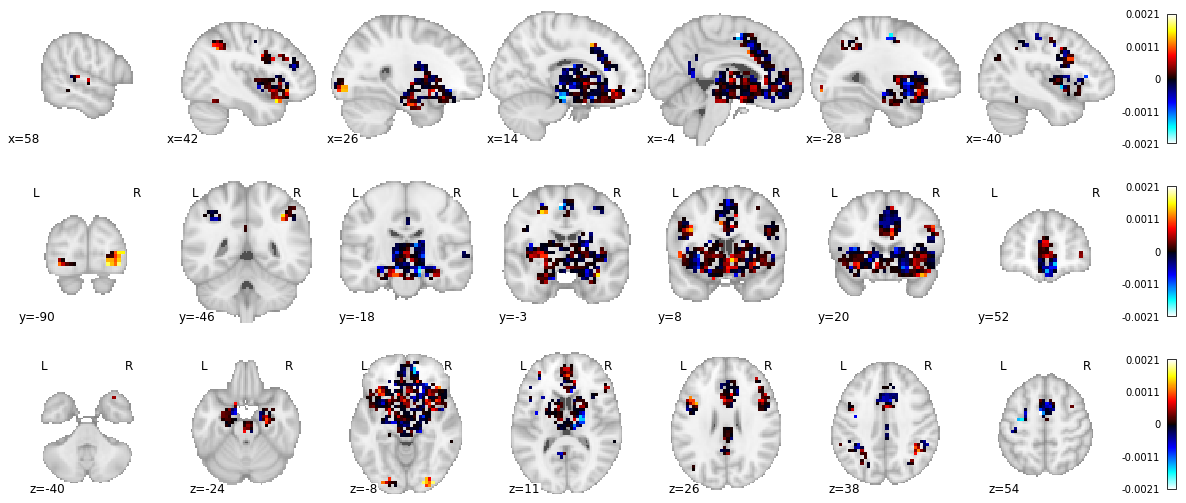

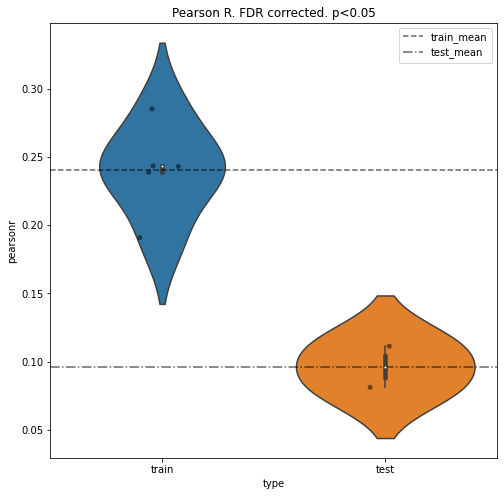

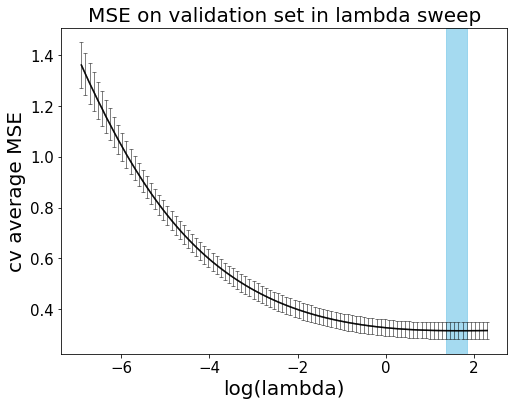

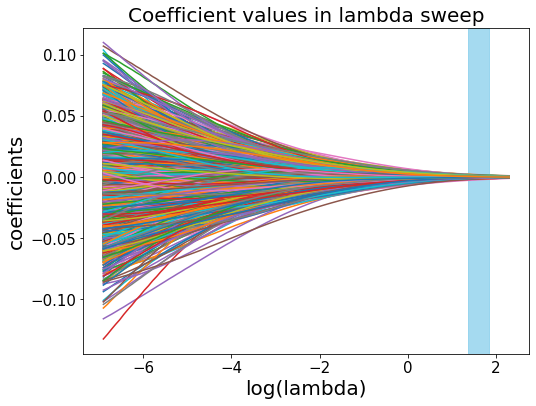

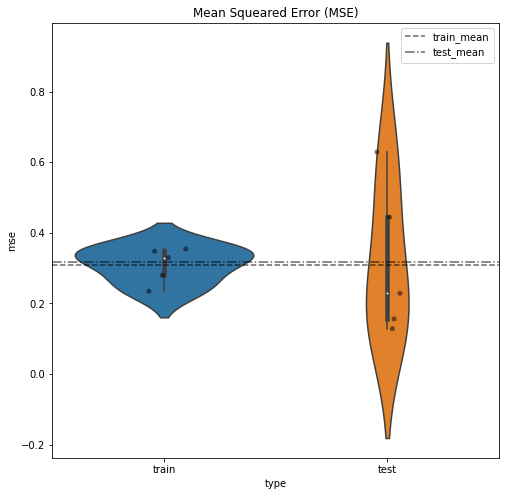

INFO: report(s)-['brainmap', 'pearsonr', 'elasticnet', 'mse'] is(are) done.
INFO: running done.


In [13]:
from mbfmri.core.engine import run_mbfmri


_ = run_mbfmri(analysis='mvpa',                     # name of analysis
               bids_layout='mini_bornstein2017',    # data
               mvpa_model='elasticnet',             # MVPA model
               skip_compmodel=True,
               feature_name='zoom2rgrout',          # indentifier for processed fMRI data
               task_name='multiarmedbandit',        # identifier for task
               process_name='PrecalculatedPEchosen',# identifier for target latent process
               subjects='all',                      # list of subjects to include
               method='5-fold',                     # type of cross-validation
               report_path=report_path,             # save path for reporting results
               confounds=["trans_x", "trans_y",     # list of confounds to regress out
                          "trans_z", "rot_x",
                          "rot_y", "rot_z"],
               n_core=4,                            # number of core for multi-processing in hBayesDM
               n_thread=4,                          # number of thread for multi-threading in generating voxel features
              )

### MLP

INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: setting functions
INFO: existing voxel mask is loaded.: 3762/116380
INFO: start processing 0 fMRI. (nii_img/thread)*(n_thread)=0*4. 8 image(s) is(are) skipped.


0it [00:00, ?it/s]

INFO: fMRI processing is done.


INFO: start model comparison-['banditNarm_lapse_decay']
INFO: individual parameters are loaded
INFO: model comparison done
                    model        value criterion
0  banditNarm_lapse_decay  2120.746911     looic
INFO: the best model is banditNarm_lapse_decay
INFO: indivudal parameters table
  subjID      Arew      Apun         R          P        xi         d
0     01  0.439838  0.502000  0.490360  14.958661  0.026151  0.416641
1     02  0.635754  0.502576  0.098867  14.968765  0.029592  0.341070
2     03  0.658329  0.502562  0.751799  14.984605  0.029453  0.440954
3     04  0.897282  0.503521  0.527837  14.979193  0.026998  0.376644
4     05  0.851341  0.503118  0.352062  14.983867  0.027800  0.390917
5     06  0.642172  0.503039  0.954614  14.955344  0.025099  0.406447
6     07  0.848062  0.502244  0.386015  14.974610  0.028043  0.382110
7     08  0.532705  0.503317  0.412858  14.953403  0.029738  0.442654
INFO: start processing 8 events.[task-multiarmedbandit, process-Qchos

8it [00:01,  7.98it/s]


INFO: events processing is done.
INFO: processed data [8/8] are plotted for quality check.
INFO: retrieving from BIDS Layout: ...rnstein2017/derivatives/mbmvpa | Subjects: 8 | Sessions: 0 | Runs: 0
      task-multiarmedbandit, process-Qchosen, feature-zoom2rgrout
INFO: start loading data


INFO: loaded data info. total-16
         subject_01: X(683, 3762), y(683, 1)
         subject_02: X(705, 3762), y(705, 1)
         subject_03: X(690, 3762), y(690, 1)
         subject_04: X(686, 3762), y(686, 1)
         subject_05: X(686, 3762), y(686, 1)
         subject_06: X(676, 3762), y(676, 1)
         subject_07: X(675, 3762), y(675, 1)
         subject_08: X(721, 3762), y(721, 1)
INFO: loaded voxel mask(46, 55, 46)
INFO: loading data done
INFO: start running the experiment. MLP_TF


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-1/5]:
         r_train                       0.34903
         r_pvalue_train                0.00000
         r_test                        0.20065
         r_pvalue_test                 0.00000
         mse_train                     0.18541
         mse_test                      0.07480


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-2/5]:
         r_train                       0.35162
         r_pvalue_train                0.00000
         r_test                        0.10810
         r_pvalue_test                 0.00032
         mse_train                     0.15742
         mse_test                      0.20027


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-3/5]:
         r_train                       0.26770
         r_pvalue_train                0.00000
         r_test                        0.12038
         r_pvalue_test                 0.00006
         mse_train                     0.17554
         mse_test                      0.14497


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-4/5]:
         r_train                       0.34507
         r_pvalue_train                0.00000
         r_test                        0.12012
         r_pvalue_test                 0.00006
         mse_train                     0.11495
         mse_test                      0.38339


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-5/5]:
         r_train                       0.31311
         r_pvalue_train                0.00000
         r_test                        0.19224
         r_pvalue_test                 0.00000
         mse_train                     0.18846
         mse_test                      0.07662
INFO: output statistics
         weights                       5
         pred_train                    5
         y_train                       5
         y_test                        5
         pred_test                     5
         shap_values                   5
         shap_sample                   5
         shap_pred                     5
INFO: fit statistics
         r_train_mean                  0.32531
         r_train_std                   0.03575
         r_pvalue_train_<=0.001        100.00%
         r_pvalue_train_<=0.005        100.00%
         r_pvalue_train_<=0.01         100.00%
         r_test_mean                   0.14830
         r_test_std 

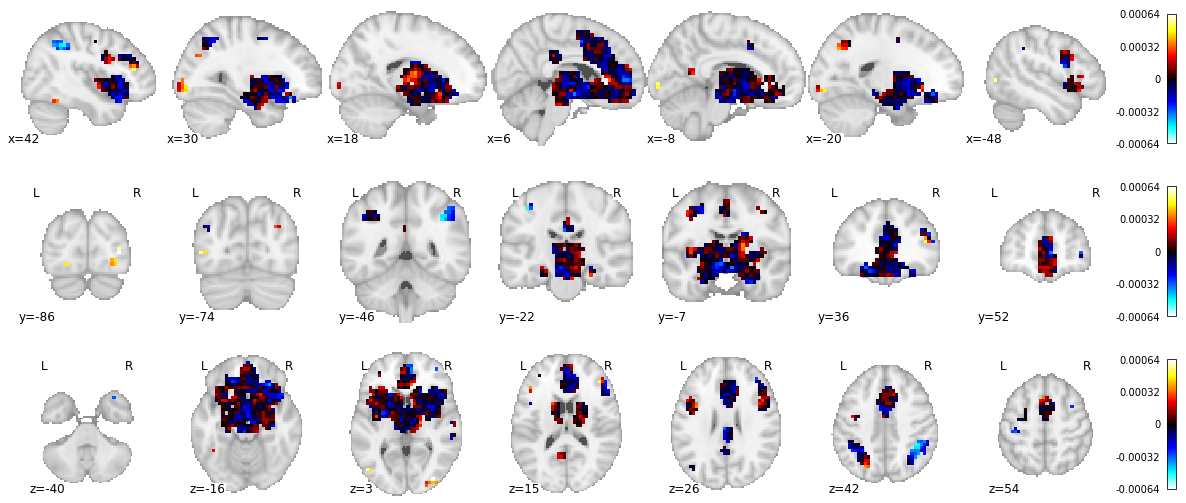

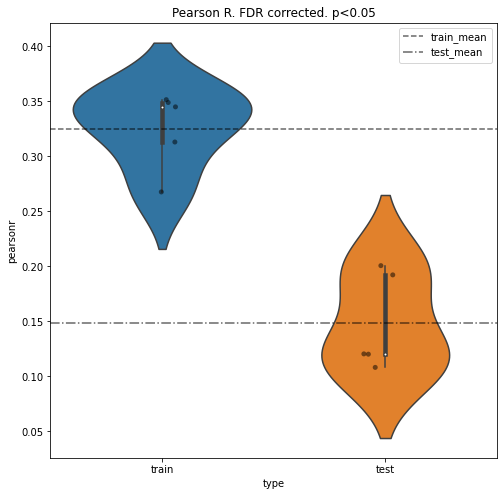

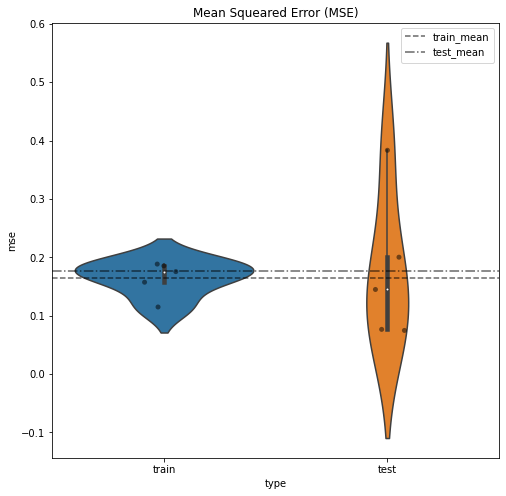

INFO: report(s)-['brainmap', 'pearsonr', 'mse'] is(are) done.
INFO: running done.


In [14]:
_ = run_mbfmri(analysis='mvpa',                     # name of analysis
               bids_layout='mini_bornstein2017',    # data
               mvpa_model='mlp',                    # MVPA model
               dm_model= 'banditNarm_lapse_decay',  # computational model
               feature_name='zoom2rgrout',          # indentifier for processed fMRI data
               task_name='multiarmedbandit',        # identifier for task
               process_name='Qchosen',              # identifier for target latent process
               subjects='all',                      # list of subjects to include
               method='5-fold',                     # type of cross-validation
               report_path=report_path,             # save path for reporting results
               confounds=["trans_x", "trans_y",     # list of confounds to regress out
                          "trans_z", "rot_x",
                          "rot_y", "rot_z"],
               n_core=4,                            # number of core for multi-processing in hBayesDM
               n_thread=4,                          # number of thread for multi-threading in generating voxel features
              )

### CNN

INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: start loading BIDSLayout
INFO: fMRIPrep is loaded
INFO: template space is not designated. find most common space
INFO: selected space_name is MNI152NLin2009cAsym
INFO: MB-MVPA is loaded
INFO: target subjects-all
INFO: No general TR is found. it will be searched for each run by json file.
INFO: 8 file(s) in Original & fMRIPrep.
INFO: setting functions
INFO: existing voxel mask is loaded.: 3762/116380
INFO: start processing 0 fMRI. (nii_img/thread)*(n_thread)=0*4. 8 image(s) is(are) skipped.


0it [00:00, ?it/s]

INFO: fMRI processing is done.


INFO: start model comparison-['banditNarm_lapse_decay']
INFO: individual parameters are loaded
INFO: model comparison done
                    model        value criterion
0  banditNarm_lapse_decay  2120.746911     looic
INFO: the best model is banditNarm_lapse_decay
INFO: indivudal parameters table
  subjID      Arew      Apun         R          P        xi         d
0     01  0.439838  0.502000  0.490360  14.958661  0.026151  0.416641
1     02  0.635754  0.502576  0.098867  14.968765  0.029592  0.341070
2     03  0.658329  0.502562  0.751799  14.984605  0.029453  0.440954
3     04  0.897282  0.503521  0.527837  14.979193  0.026998  0.376644
4     05  0.851341  0.503118  0.352062  14.983867  0.027800  0.390917
5     06  0.642172  0.503039  0.954614  14.955344  0.025099  0.406447
6     07  0.848062  0.502244  0.386015  14.974610  0.028043  0.382110
7     08  0.532705  0.503317  0.412858  14.953403  0.029738  0.442654
INFO: start processing 8 events.[task-multiarmedbandit, process-Qchos

8it [00:01,  7.66it/s]


INFO: events processing is done.
INFO: processed data [8/8] are plotted for quality check.
INFO: retrieving from BIDS Layout: ...rnstein2017/derivatives/mbmvpa | Subjects: 8 | Sessions: 0 | Runs: 0
      task-multiarmedbandit, process-Qchosen, feature-zoom2rgrout
INFO: start loading data


INFO: loaded data info. total-16
         subject_01: X(683, 46, 55, 46), y(683, 1)
         subject_02: X(705, 46, 55, 46), y(705, 1)
         subject_03: X(690, 46, 55, 46), y(690, 1)
         subject_04: X(686, 46, 55, 46), y(686, 1)
         subject_05: X(686, 46, 55, 46), y(686, 1)
         subject_06: X(676, 46, 55, 46), y(676, 1)
         subject_07: X(675, 46, 55, 46), y(675, 1)
         subject_08: X(721, 46, 55, 46), y(721, 1)
INFO: loaded voxel mask(46, 55, 46)
INFO: loading data done
INFO: start running the experiment. CNN_TF


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-1/5]:
         r_train                       0.36614
         r_pvalue_train                0.00000
         r_test                        0.09463
         r_pvalue_test                 0.00165
         mse_train                     0.17248
         mse_test                      0.10335


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-2/5]:
         r_train                       0.31948
         r_pvalue_train                0.00000
         r_test                        0.05202
         r_pvalue_test                 0.08402
         mse_train                     0.14840
         mse_test                      0.21791


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-3/5]:
         r_train                       0.21575
         r_pvalue_train                0.00000
         r_test                        0.09149
         r_pvalue_test                 0.00234
         mse_train                     0.17076
         mse_test                      0.14947


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-4/5]:
         r_train                       0.41106
         r_pvalue_train                0.00000
         r_test                        0.08750
         r_pvalue_test                 0.00362
         mse_train                     0.10502
         mse_test                      0.36648


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


INFO: fitting result[repeat-1/1,fold-5/5]:
         r_train                       0.57122
         r_pvalue_train                0.00000
         r_test                        0.01212
         r_pvalue_test                 0.68750
         mse_train                     0.13379
         mse_test                      0.11798
INFO: output statistics
         weights                       5
         pred_train                    5
         y_train                       5
         y_test                        5
         pred_test                     5
         shap_values                   5
         shap_sample                   5
         shap_pred                     5
INFO: fit statistics
         r_train_mean                  0.37673
         r_train_std                   0.13068
         r_pvalue_train_<=0.001        100.00%
         r_pvalue_train_<=0.005        100.00%
         r_pvalue_train_<=0.01         100.00%
         r_test_mean                   0.06755
         r_test_std 

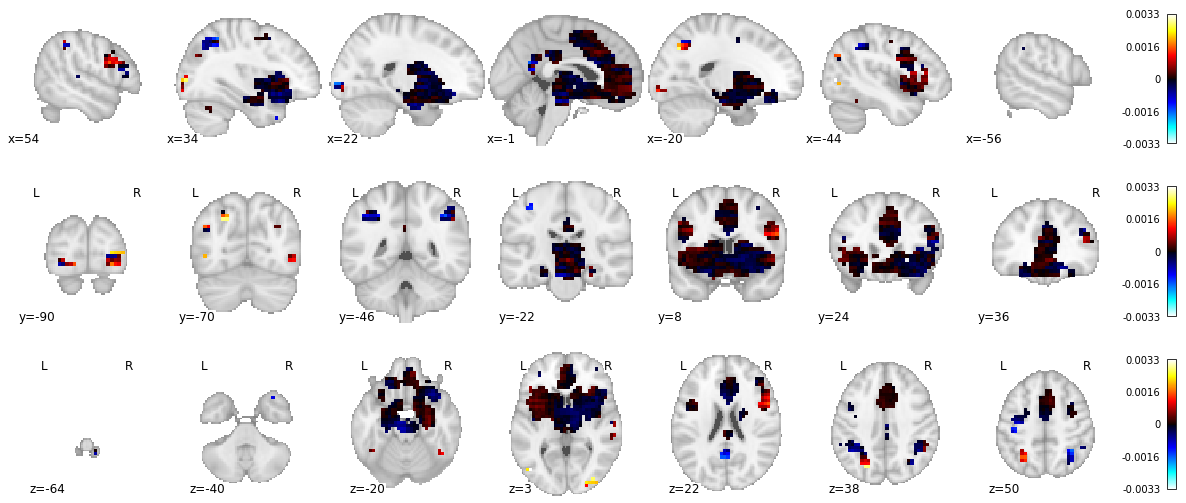

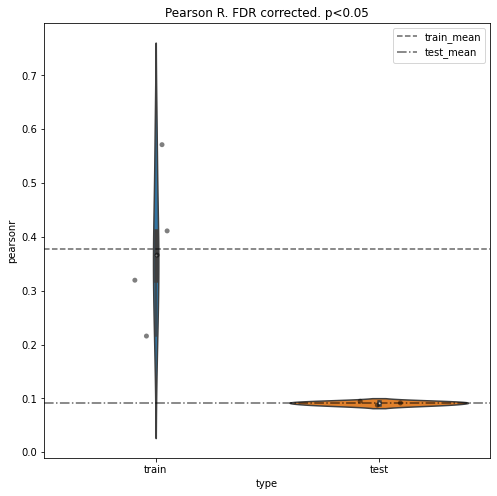

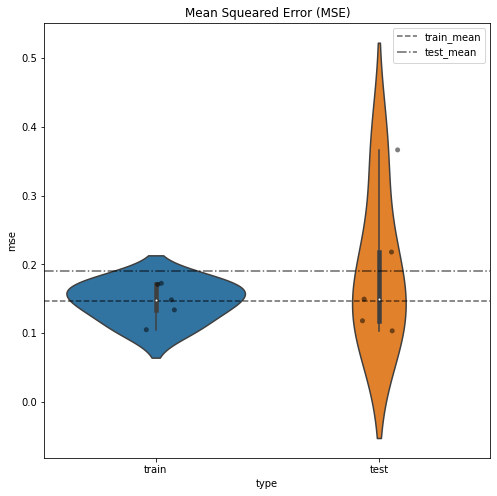

INFO: report(s)-['brainmap', 'pearsonr', 'mse'] is(are) done.
INFO: running done.


In [15]:
_ = run_mbfmri(analysis='mvpa',                     # name of analysis
               bids_layout='mini_bornstein2017',    # data
               mvpa_model='cnn',                    # MVPA model
               dm_model= 'banditNarm_lapse_decay',  # computational model
               feature_name='zoom2rgrout',          # indentifier for processed fMRI data
               task_name='multiarmedbandit',        # identifier for task
               process_name='Qchosen',              # identifier for target latent process
               subjects='all',                      # list of subjects to include
               method='5-fold',                     # type of cross-validation
               report_path=report_path,             # save path for reporting results
               confounds=["trans_x", "trans_y",     # list of confounds to regress out
                          "trans_z", "rot_x",
                          "rot_y", "rot_z"],
               n_core=4,                            # number of core for multi-processing in hBayesDM
               n_thread=4,                          # number of thread for multi-threading in generating voxel features
              )

### Model selection

In [ ]:
from mbfmri.core.engine import run_mbfmri


_ = run_mbfmri(analysis='mvpa',                     # name of analysis
               bids_layout='mini_bornstein2017',    # data
               mvpa_model='elasticnet',             # MVPA model
               dm_model= ['banditNarm_lapse_decay', # computational model candidates
#                           'banditNarm_delta',
                          'banditNarm_2par_lapse',
                          'banditNarm_4par',
                          'banditNarm_lapse',
                          'banditNarm_singleA_lapse'],
               feature_name='zoom2rgrout',          # indentifier for processed fMRI data
               task_name='multiarmedbandit',        # identifier for task
               process_name='PEchosen',             # identifier for target latent process
               subjects='all',                      # list of subjects to include
               method='5-fold',                     # type of cross-validation
               report_path=report_path,             # save path for reporting results
               confounds=["trans_x", "trans_y",     # list of confounds to regress out
                          "trans_z", "rot_x",
                          "rot_y", "rot_z"],
               n_core=4,                            # number of core for multi-processing in hBayesDM
               n_thread=4,                          # number of thread for multi-threading in generating voxel features
               srefit_compmodel=True,               # indicate if reffiting comp. model is required
              )